**Import all the librairies and functions**

In [1]:
import os
import sys
import importlib
import json
from dataclasses import dataclass, field, fields
from itertools import compress
import csv
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
from scipy import signal
from scipy.signal import butter, filtfilt, freqz
import openpyxl
from openpyxl import Workbook, load_workbook
import xlrd
#MNE
import mne
from mne.time_frequency import tfr_morlet
from importlib import reload 
from os.path import join, dirname, realpath, exists

#load poly5reader
# define current working directory (the one that contains this notebook): this is the project_path
os.chdir('c:\\Users\\Juliette\\Research\\Projects\\Synchronization project\\Code\\Synchronization')
project_path = os.getcwd()

# change temporarily the working directory to go fetch the poly5 reader: this is the code_path
os.chdir(os.path.dirname(os.getcwd()))
os.chdir(os.path.join(os.getcwd(), 'tmsi-python-interface-main'))
code_path = os.getcwd()

print (f'working dir for analysis:{project_path}')
print (f'working dir to go fetch Poly5 reader:{code_path}')

#fetch the poly5 reader
from TMSiFileFormats.file_readers import Poly5Reader

# set the working directory back to the project_path
os.chdir(project_path)

# change temporarily the working directory to go fetch the peakdetect funciton: this is the code_path
os.chdir(os.path.dirname(os.getcwd()))
os.chdir(os.path.join(os.getcwd(), 'peakdetect-master'))
code_path = os.getcwd()

print (f'working dir for analysis:{project_path}')
print (f'working dir to go fetch peakdetect:{code_path}')

#fetch the poly5 reader
from peakdetect import peakdetect

# set the working directory back to the project_path
os.chdir(project_path)


# load pyPerceive functions
os.chdir('c:\\Users\\Juliette\\Research\\Projects\\Synchronization project\\Code\\Synchronization')
project_path = os.getcwd()
os.chdir(os.path.dirname(os.getcwd()))
os.chdir(os.path.join(os.getcwd(), 'PyPerceive'))
os.chdir(os.path.join(os.getcwd(), 'code'))
code_path = os.getcwd()
print (f'working dir for analysis:{project_path}')
print (f'working dir to go fetch PyPerceive functions:{code_path}')

from PerceiveImport.classes import (
    main_class, modality_class, metadata_class,
    session_class, condition_class, task_class,
    contact_class, run_class
)
import PerceiveImport.methods.load_rawfile as load_rawfile
import PerceiveImport.methods.find_folders as find_folders
import PerceiveImport.methods.metadata_helpers as metaHelpers

#reset the proper working directory for the analysis
os.chdir(project_path)

working dir for analysis:c:\Users\Juliette\Research\Projects\Synchronization project\Code\Synchronization
working dir to go fetch Poly5 reader:c:\Users\Juliette\Research\Projects\Synchronization project\Code\tmsi-python-interface-main
working dir for analysis:c:\Users\Juliette\Research\Projects\Synchronization project\Code\Synchronization
working dir to go fetch peakdetect:c:\Users\Juliette\Research\Projects\Synchronization project\Code\peakdetect-master
working dir for analysis:c:\Users\Juliette\Research\Projects\Synchronization project\Code\Synchronization
working dir to go fetch PyPerceive functions:c:\Users\Juliette\Research\Projects\Synchronization project\Code\PyPerceive\code


**Open LFP data**

if PyPerceive:

In [ ]:
# define an example instance and fill in the values of the dataclass PerceiveData 
# choose the values you are interested in analyzing further

sub061 = main_class.PerceiveData(
    sub = "061", 
    incl_modalities=['survey', 'streaming'],
    incl_session = ['postop', 'fu12m', 'fu18m'],
    incl_condition =['m0s0', ],
    incl_task = ["rest"],
    incl_contact = ["RingL", "SegmInterR", "SegmIntraR"],
    import_json=False,
    warn_for_metaNaNs=True,
    # use_bids=True,  # TODO: add to functionality
)

#store the MNE object in the variable
sub061_data = sub061.streaming.postop.m0s0.rest.run1.data
#look at the MNE object
sub061_data

without pyPerceive:

Example with sub-020 23MFU M1S0 Rest:

In [70]:
datapath = 'C:\\Users\\Juliette\\OneDrive\\Bureau\\Recordings\\PERCEPT recordings\\sub-020\\23MFU\\MedOn\\sub-20210329PStn\\ses-2023022111165459\\ieeg'
filename = 'sub-20210329PStn_ses-2023022111165459_run-BrainSense20230221121800.mat'
data = mne.io.read_raw_fieldtrip(        
	os.path.join(datapath, filename),        
	info={}, # add info here        
	data_name='data',  # name of heading dict/ variable of original MATLAB object    
)
data.ch_names
n_chan = len(data.ch_names)
data.n_times #number of samples
data.times #timepoints set to zero
data._data # channel trials
data.info['sfreq'] # sampling frequency
time_duration = (data.n_times/data.info['sfreq']).astype(float)
time_duration_ms=time_duration*1000
print(     
	f'The data object has:\n\t{data.n_times} time samples,'      
	f'\n\tand a sample frequency of {data.info["sfreq"]} Hz'      
	f'\n\twith a recording duration of {time_duration} seconds.'      
	f'\n\t{n_chan} channels were labeled as \n{data.ch_names}.')


Creating RawArray with float64 data, n_channels=6, n_times=41375
    Range : 0 ... 41374 =      0.000 ...   165.496 secs
Ready.
The data object has:
	41375 time samples,
	and a sample frequency of 250.0 Hz
	with a recording duration of 165.5 seconds.
	6 channels were labeled as 
['LFP_Stn_L_02', 'LFP_Stn_R_02', 'LFP_Stn_L_02_PEAK14Hz_THR20-30_AVG3000ms', 'LFP_Stn_R_02_PEAK14Hz_THR20-30_AVG3000ms', 'STIM_L_130Hz_60us', 'STIM_R_130Hz_60us'].


c:\Users\Juliette\anaconda3\envs\mne\lib\site-packages\pymatreader\utils.py:230: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '
C:\Users\Juliette\AppData\Local\Temp\ipykernel_6472\1481395607.py:3: RuntimeWarning: The supplied FieldTrip structure does not have an elec or grad field. No channel locations will extracted and the kind of channel might be inaccurate.
  data = mne.io.read_raw_fieldtrip(
C:\Users\Juliette\AppData\Local\Temp\ipykernel_6472\1481395607.py:3: RuntimeWarning: Cannot guess the correct type of channel LFP_Stn_L_02. Making it a MISC channel.
  data = mne.io.read_raw_fieldtrip(
C:\Users\Juliette\AppData\Local\Temp\ipykernel_6472\1481395607.py:3: RuntimeWarning: Cannot guess the correct type of channel LFP_Stn_R_02. Making it a MISC channel.
  data = mne.io.read_raw_fieldtrip(
C:\Users\Juliette\AppData\Local\Temp\ipykernel_6472\

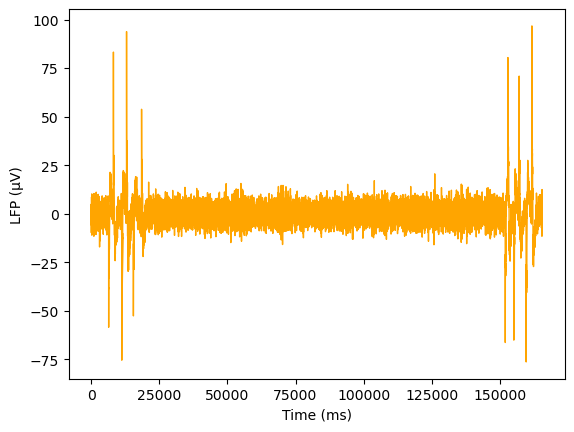

In [71]:
LFP_Stn_L_02 = data.get_data()[0]
x1_time=np.arange(0,time_duration_ms,time_duration_ms/data.n_times)
df_LFP=pd.DataFrame(x1_time,LFP_Stn_L_02)
plt.xlabel('Time (ms)')
plt.ylabel('LFP (µV)')
plt.plot(x1_time,LFP_Stn_L_02, linewidth=1,color='orange')


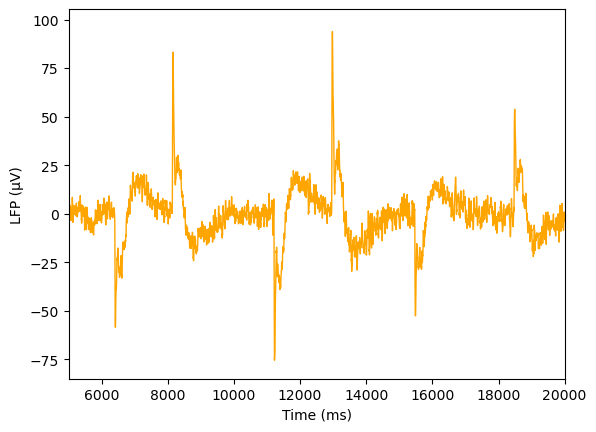

In [72]:
plt.xlabel('Time (ms)')
plt.ylabel('LFP (µV)')
plt.xlim(5000,20000)
plt.plot(x1_time,LFP_Stn_L_02, linewidth=1,color='orange')

In [73]:
artefact_start_time_LFP = 0
i = 0
for i in range(0,len(LFP_Stn_L_02)-1):
    if (LFP_Stn_L_02[i] <= -50):
        artefact_start_time_LFP = x1_time[i]
        break
    else:
        i = i+1
print(f'the first artefact in the LFP starts at \n\t{artefact_start_time_LFP} ms')

the first artefact in the LFP starts at 
	6408.0 ms


In [74]:
artefact_end_time_LFP = 0
j = 0
for j in range((int(artefact_start_time_LFP/1000*data.info["sfreq"])),len(LFP_Stn_L_02)-1):
    if (LFP_Stn_L_02[j] >= 50):
        artefact_end_time_LFP = x1_time[j]
        break
    else:
        j = j+1
print(f'the first artefact in the LFP ends at \n\t{artefact_end_time_LFP} ms')

the first artefact in the LFP ends at 
	8144.0 ms


In [75]:
LFP_artefact_duration = artefact_end_time_LFP - artefact_start_time_LFP
print(f'the first artefact in the LFP lasts \n\t{LFP_artefact_duration} ms')

the first artefact in the LFP lasts 
	1736.0 ms


In [76]:
second_artefact_start_time_LFP = 0
k = 0
for k in range((int(artefact_end_time_LFP/1000*data.info["sfreq"])),len(LFP_Stn_L_02)-1):
    if (LFP_Stn_L_02[k] <= -50):
        second_artefact_start_time_LFP = x1_time[k]
        break
    else:
        k = k+1
print(f'the second artefact in the LFP starts at \n\t{second_artefact_start_time_LFP} ms')

the second artefact in the LFP starts at 
	11216.0 ms


In [77]:
delay_between_artefacts_LFP = second_artefact_start_time_LFP - artefact_start_time_LFP
delay_between_artefacts_LFP

4808.0

Loop to detect all start-times and end-times, compile those values in a list

In [78]:
#initialize variables (lists and state)
artefacts_x_LFP = []
artefacts_y_LFP = []
state_LFP:str = "stim_OFF"

#start looking at each value one by one and append the timepoint to the proper list depending on the state and threshold crossed
for n in range(0,(len(LFP_Stn_L_02)-1)):
    if (LFP_Stn_L_02[n] <= -50) and (state_LFP != "stim_ON"):
        artefacts_x_LFP.append(x1_time[n])
        artefacts_y_LFP.append(LFP_Stn_L_02[n])
        state_LFP = "stim_ON"
    else:
        n = n+1
         
    if (LFP_Stn_L_02[n] >= 50) and (state_LFP != "stim_OFF"):
        artefacts_x_LFP.append(x1_time[n])
        artefacts_y_LFP.append(LFP_Stn_L_02[n])
        state_LFP = "stim_OFF"
    else:
        n = n+1
print(
    f'\n\tthe artefacts in the LFP are at: \t{artefacts_x_LFP} ms')




	the artefacts in the LFP are at: 	[6408.0, 8144.0, 11216.0, 12964.0, 15484.0, 18484.0, 151968.0, 152940.0, 155112.0, 157064.0, 159644.0, 161736.0] ms


Take the lowest/highest points from the artefact:

In [79]:
#initialize variables (lists and state)
artefacts_x_LFP = []
artefacts_y_LFP = []
state_LFP:str = "stim_OFF"

#start looking at each value one by one and append the timepoint to the proper list depending on the state and threshold crossed
for n in range(0,(len(LFP_Stn_L_02)-1)):
    if (LFP_Stn_L_02[n] <= -50) and (state_LFP != "stim_ON") and (LFP_Stn_L_02[n] < LFP_Stn_L_02[n+1]) and (LFP_Stn_L_02[n] < LFP_Stn_L_02[n-1]):
        artefacts_x_LFP.append(x1_time[n])
        artefacts_y_LFP.append(LFP_Stn_L_02[n])
        state_LFP = "stim_ON"
    else:
        n = n+1
         
    if (LFP_Stn_L_02[n] >= 50) and (state_LFP != "stim_OFF") and (LFP_Stn_L_02[n] > LFP_Stn_L_02[n+1]) and(LFP_Stn_L_02[n] > LFP_Stn_L_02[n-1]):
        artefacts_x_LFP.append(x1_time[n])
        artefacts_y_LFP.append(LFP_Stn_L_02[n])
        state_LFP = "stim_OFF"
    else:
        n = n+1
print(
    f'\n\tthe artefacts in the LFP are at: \t{artefacts_x_LFP} ms')


	the artefacts in the LFP are at: 	[6412.0, 8156.0, 11224.0, 12976.0, 15488.0, 18488.0, 151976.0, 152952.0, 155116.0, 157072.0, 159652.0, 161752.0] ms


Change the points detected as "end" of artefact:

In [183]:
#initialize variables (lists and state)
artefacts_x_LFP = []
artefacts_y_LFP = []
state_LFP:str = "stim_OFF"

#start looking at each value one by one and append the timepoint to the proper list depending on the state and threshold crossed
for n in range(0,(len(LFP_Stn_L_02)-1)):
    if (LFP_Stn_L_02[n] <= -50) and (state_LFP != "stim_ON") and (LFP_Stn_L_02[n] < LFP_Stn_L_02[n+1]) and (LFP_Stn_L_02[n] < LFP_Stn_L_02[n-1]):
        artefacts_x_LFP.append(x1_time[n])
        artefacts_y_LFP.append(LFP_Stn_L_02[n])
        state_LFP = "stim_ON"
    else:
        n = n+1
         
    if (LFP_Stn_L_02[n] >= 30) and (state_LFP != "stim_OFF"):
        artefacts_x_LFP.append(x1_time[n])
        artefacts_y_LFP.append(LFP_Stn_L_02[n])
        state_LFP = "stim_OFF"
    else:
        n = n+1
print(
    f'\n\tthe artefacts in the LFP are at: \t{artefacts_x_LFP} ms')


	the artefacts in the LFP are at: 	[6412.0, 8144.0, 11224.0, 12960.0, 15488.0, 18476.0, 151976.0, 152940.0, 155116.0, 157060.0, 159652.0, 161732.0] ms


Plot artefact points on raw signal to visualize them

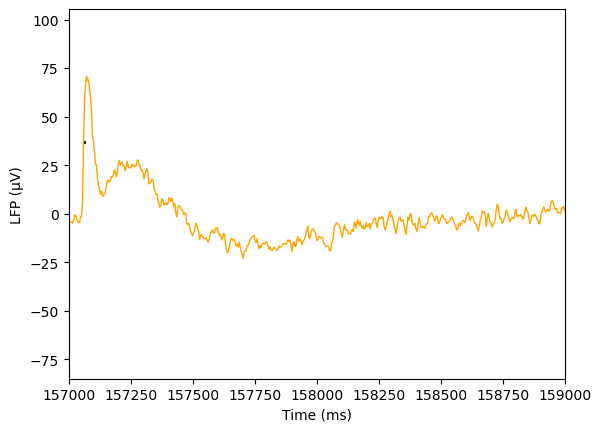

In [229]:
plt.xlabel('Time (ms)')
plt.ylabel('LFP (µV)')
plt.xlim(157000,159000)
plt.plot(x1_time,LFP_Stn_L_02, linewidth=1,color='orange')
#plt.plot(x1_time[:-1],np.diff(LFP_Stn_L_13), linewidth=1,color='green')
plt.scatter(artefacts_x_LFP,artefacts_y_LFP,color='black',s=2)


Determine duration of each artefact detected

In [185]:
artefact_duration_LFP=[]
range_o=np.arange(1,len(artefacts_x_LFP),2)
range_p=np.arange(0,len(artefacts_x_LFP),2)

for o,p in zip(range_o,range_p):
        artefact_duration_LFP.append(artefacts_x_LFP[o]-artefacts_x_LFP[p])

artefact_duration_LFP

[1732.0, 1736.0, 2988.0, 964.0, 1944.0, 2080.0]

**Open sensor-data**

In [39]:
TMSi_data = Poly5Reader()

# Extract the samples and channel names from the Poly5Reader object
samples = TMSi_data.samples
ch_names = TMSi_data.ch_names

# Conversion to MNE raw array

toMNE = True
mne_object = TMSi_data.read_data_MNE()

# Retrieve the MNE RawArray info and sample data
info_mne = mne_object.info
samples_mne = mne_object._data
    
#mne_object.plot(start = 5, duration = 5, n_channels = 2) #(only if I want to plot in interactive viewer)

n_chan = len(mne_object.ch_names)
time_duration = (mne_object.n_times/mne_object.info['sfreq']).astype(float)
time_duration_ms=time_duration*1000

print(     
	f'The data object has:\n\t{mne_object.n_times} time samples,'      
	f'\n\tand a sample frequency of {mne_object.info["sfreq"]} Hz'      
	f'\n\twith a recording duration of {time_duration} seconds.'      
	f'\n\t{n_chan} channels were labeled as \n{mne_object.ch_names}.')

x2_time=np.arange(0,time_duration_ms,time_duration_ms/mne_object.n_times)


Reading file  C:/Users/Juliette/OneDrive/Bureau/Recordings/TMSi recordings/sub-020/23MFU/sub_020_23mfu_M1S0_BrStr_Rest - 20230221T130904/sub_020_23mfu_M1S0_BrStr_Rest-20230221T130904.DATA.Poly5
	 Number of samples:  748396 
	 Number of channels:  14 
	 Sample rate: 4000 Hz
Done reading data.
Creating RawArray with float64 data, n_channels=14, n_times=748396
    Range : 0 ... 748395 =      0.000 ...   187.099 secs
Ready.
The data object has:
	748396 time samples,
	and a sample frequency of 4000.0 Hz
	with a recording duration of 187.099 seconds.
	14 channels were labeled as 
['BIP 01', 'BIP 02', 'BIP 03', 'X-0', 'Y-0', 'Z-0', 'X-1', 'Y-1', 'Z-1', 'X-AXIS', 'Y-AXIS', 'Z-AXIS', 'STATUS', 'Counter 2power24'].


c:\Users\Juliette\Research\Projects\Synchronization project\Code\tmsi-python-interface-main\TMSiFileFormats\file_readers\poly5reader.py:92: RuntimeWarning: Channel names are not unique, found duplicates for: {'X', 'Y', 'Z'}. Applying running numbers for duplicates.
  info = mne.create_info(ch_names=labels, sfreq=fs, ch_types=types_clean)


In [36]:
mne_object.plot(start = 5, duration = 5, n_channels = 2)

Using qt as 2D backend.


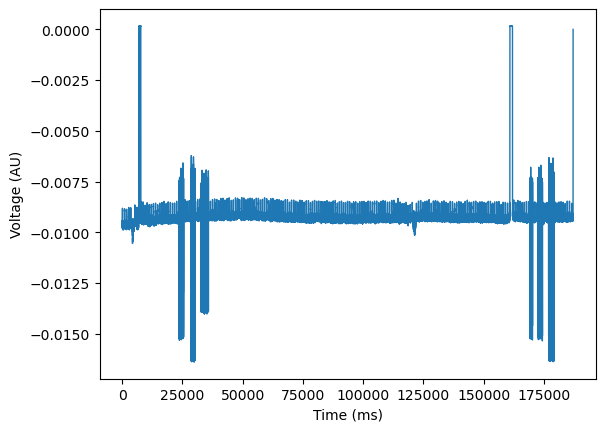

In [40]:
BIP01 = mne_object.get_data()[0]
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (AU)')
plt.plot(x2_time,BIP01,linewidth=1)
#plt.xlim(23000,25000)
plt.show()

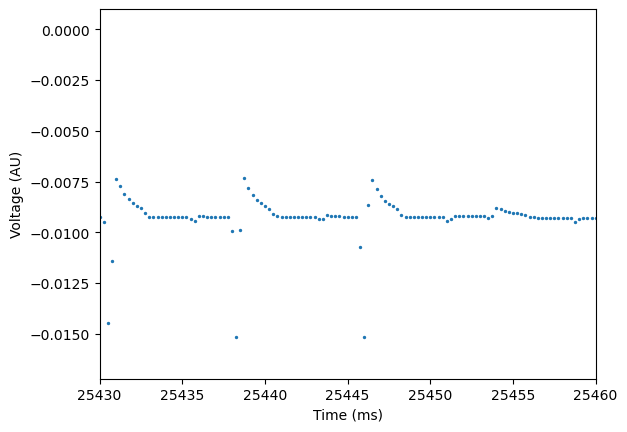

In [41]:
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (AU)')
plt.scatter(x2_time,BIP01,linewidth=1,s=2)
plt.xlim(25430, 25460)
#plt.ylim(-0.002,0.001)
plt.show()

In [59]:
len(BIP01)
time_point=32000
#index_start = int(time_point/1000*mne_object.info['sfreq'])
index_start=0

artefact_start_time_TMSi = 0
l = 0
for l in range(index_start,len(BIP01)-1):
    if (BIP01[l] <= -0.0125):
        artefact_start_time_TMSi = x2_time[l]
        break
    else:
        l = l+1
print(f'the first artefact in the TMSi recording starts at \n\t{artefact_start_time_TMSi} ms')

the first artefact in the TMSi recording starts at 
	23713.5 ms


Code which works: **!check again each point one by one!**

In [149]:
#initialize variables (lists and state)
artefacts_x_TMSi = []
artefacts_y_TMSi = []
stimON = False
thresh = -0.0125


#start looking at each value one by one and append the timepoint to the list depending on the state and threshold crossed
for q in range(0,(len(BIP01)-1)):
    if (stimON == False) and (BIP01[q] <= thresh) and (BIP01[q] < BIP01[q+1]) and (BIP01[q] < BIP01[q-1]):
        artefacts_x_TMSi.append(x2_time[q])
        artefacts_y_TMSi.append(BIP01[q])
        stimON = True
        q = q+1
    if (stimON == True) and (BIP01[q] <= thresh) and (BIP01[q] < BIP01[q+1]) and (BIP01[q] < BIP01[q-1]):
        if (all(BIP01[(q+3):(q+100)] > thresh)):
            artefacts_x_TMSi.append(x2_time[q])
            artefacts_y_TMSi.append(BIP01[q])
            stimON = False
            q = q+1
        else:
            q = q+1
    else:
        q = q+1


print(
    f'\n\tthe artefacts in the TMSi are at: \t{artefacts_x_TMSi} ms')




	the artefacts in the TMSi are at: 	[23713.5, 25446.0, 28526.0, 30266.25, 32784.25, 35779.75, 169279.75, 170250.0, 172421.25, 174369.5, 176956.75, 179043.5] ms


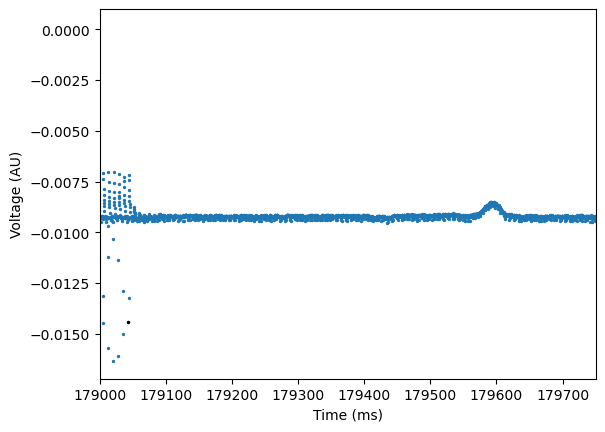

In [225]:
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (AU)')
plt.xlim(179000,179750)
plt.scatter(x2_time,BIP01,linewidth=1,s=2)
plt.scatter(artefacts_x_TMSi,artefacts_y_TMSi,color='black',s=2)
plt.show()

Determine duration of each artefact detected

In [186]:
artefact_duration_TMSi=[]
range_r=np.arange(1,len(artefacts_x_TMSi),2)
range_s=np.arange(0,len(artefacts_x_TMSi),2)

for r,s in zip(range_r,range_s):
        artefact_duration_TMSi.append(artefacts_x_TMSi[r]-artefacts_x_TMSi[s])

print(     
	f'The artefacts in the LFP last \t{artefact_duration_LFP} ms,'      
	f'\n\tand the artefacts in the TMSi datas last {artefact_duration_TMSi} ms')


The artefacts in the LFP last 	[1732.0, 1736.0, 2988.0, 964.0, 1944.0, 2080.0] ms,
	and the artefacts in the TMSi datas last [1732.5, 1740.25, 2995.5, 970.25, 1948.25, 2086.75] ms


Calculate difference between LFP and TMSi:

In [187]:
diff_duration=[]
t=0
for t in (np.arange(0,len(artefact_duration_LFP),1)):
    diff_duration.append(artefact_duration_LFP[t]-artefact_duration_TMSi[t])
diff_duration

[-0.5, -4.25, -7.5, -6.25, -4.25, -6.75]

--> I think that because the difference in duration is not higher and higher, it doesn't come from a difference in internal clocks, but it might rather be that what we detect as the beginning or the end is a little bit different from one artefact to another one.

**Downsampling TMSi datas**

In [153]:
BIP01_df = pd.DataFrame({'time (ms)':x2_time, 'y':BIP01})
BIP01_df

,time (ms),y
0,0.00,-0.009534
1,0.25,-0.009534
2,0.50,-0.009537
3,0.75,-0.009531
4,1.00,-0.009523
...,...,...
748391,187097.75,0.000000
748392,187098.00,0.000000
748393,187098.25,0.000000
748394,187098.50,0.000000


<AxesSubplot: xlabel='time (ms)'>

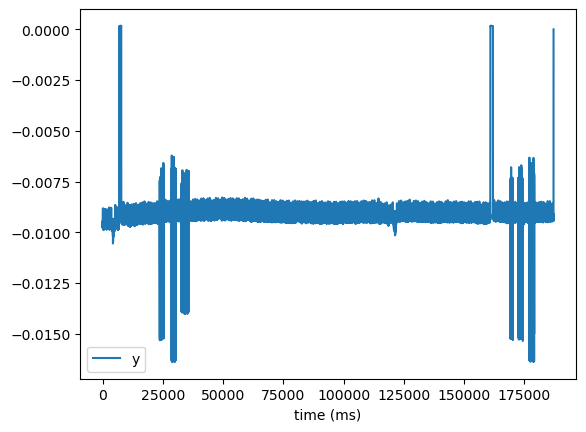

In [154]:
BIP01_df.plot(x='time (ms)',y='y')

In [155]:
sequence_interval = 0.25
downsampled_interval = 4
step_size = np.round(downsampled_interval / sequence_interval).astype("int")

downsampled_BIP01_df = BIP01_df.iloc[::step_size, :]
print(downsampled_BIP01_df)

        time (ms)         y
0             0.0 -0.009534
16            4.0 -0.009595
32            8.0 -0.009546
48           12.0 -0.009695
64           16.0 -0.009585
...           ...       ...
748320   187080.0 -0.009318
748336   187084.0 -0.009153
748352   187088.0  0.000000
748368   187092.0  0.000000
748384   187096.0  0.000000

[46775 rows x 2 columns]


<AxesSubplot: xlabel='time (ms)'>

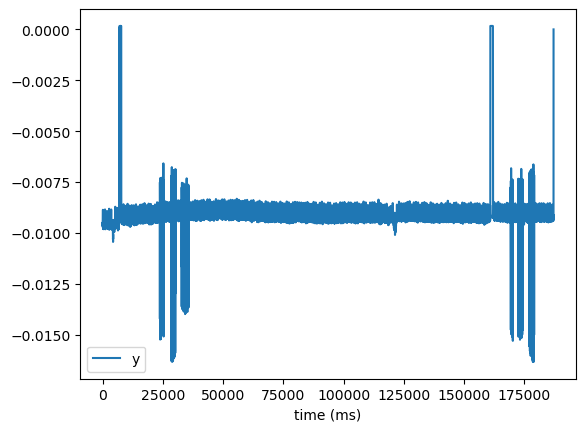

In [156]:
downsampled_BIP01_df.plot(x='time (ms)',y='y')

In [157]:
x2_time_downsampled = downsampled_BIP01_df['time (ms)'].to_numpy()
BIP01_downsampled = downsampled_BIP01_df['y'].to_numpy()


**Analyze downsampled TMSi datas**

In [158]:
#initialize variables (lists and state)
artefacts_x_TMSi_downsampled = []
artefacts_y_TMSi_downsampled = []
stimON = False
thresh = -0.0125


#start looking at each value one by one and append the timepoint to the list depending on the state and threshold crossed
for q in range(0,(len(BIP01_downsampled)-1)):
    if (stimON == False) and (BIP01_downsampled[q] <= thresh) and (BIP01_downsampled[q] < BIP01_downsampled[q+1]) and (BIP01_downsampled[q] < BIP01_downsampled[q-1]):
        artefacts_x_TMSi_downsampled.append(x2_time_downsampled[q])
        artefacts_y_TMSi_downsampled.append(BIP01_downsampled[q])
        stimON = True
        q = q+1
    if (stimON == True) and (BIP01_downsampled[q] <= thresh) and (BIP01_downsampled[q] < BIP01_downsampled[q+1]) and (BIP01_downsampled[q] < BIP01_downsampled[q-1]):
        if (all(BIP01_downsampled[(q+1):(q+150)] > thresh)):
            artefacts_x_TMSi_downsampled.append(x2_time_downsampled[q])
            artefacts_y_TMSi_downsampled.append(BIP01_downsampled[q])
            stimON = False
            q = q+1
        else:
            q = q+1
    else:
        q = q+1


print(
    f'\n\tthe artefacts in the TMSi are at: \t{artefacts_x_TMSi_downsampled} ms')



	the artefacts in the TMSi are at: 	[23752.0, 25392.0, 28580.0, 30228.0, 32792.0, 35772.0, 169372.0, 170196.0, 172460.0, 174308.0, 176980.0, 179036.0] ms


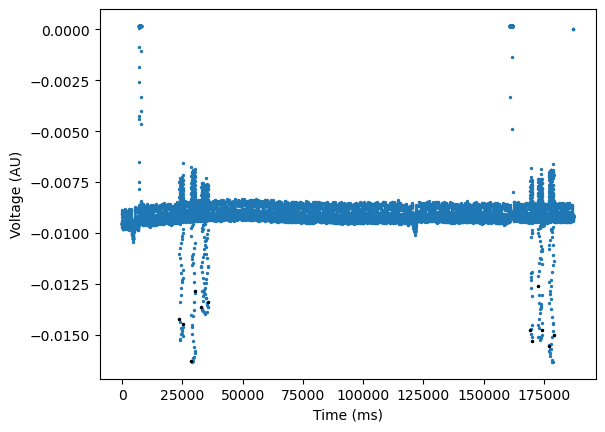

In [159]:
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (AU)')
#plt.xlim(30200,30300)
plt.scatter(x2_time_downsampled,BIP01_downsampled,linewidth=1,s=2)
plt.scatter(artefacts_x_TMSi_downsampled,artefacts_y_TMSi_downsampled,color='black',s=2)
plt.show()

In [160]:
artefact_duration_TMSi_downsampled=[]
range_r=np.arange(1,len(artefacts_x_TMSi_downsampled),2)
range_s=np.arange(0,len(artefacts_x_TMSi_downsampled),2)

for r,s in zip(range_r,range_s):
        artefact_duration_TMSi_downsampled.append(artefacts_x_TMSi_downsampled[r]-artefacts_x_TMSi_downsampled[s])

print(     
	f'The artefacts in the LFP last \t{artefact_duration_LFP} ms,'      
	f'\n\tand the artefacts in the TMSi datas last {artefact_duration_TMSi_downsampled} ms')

The artefacts in the LFP last 	[1744.0, 1752.0, 3000.0, 976.0, 1956.0, 2100.0] ms,
	and the artefacts in the TMSi datas last [1640.0, 1648.0, 2980.0, 824.0, 1848.0, 2056.0] ms


In [161]:
diff_duration=[]
t=0
for t in (np.arange(0,len(artefact_duration_LFP),1)):
    diff_duration.append(artefact_duration_LFP[t]-artefact_duration_TMSi_downsampled[t])
diff_duration

[104.0, 104.0, 20.0, 152.0, 108.0, 44.0]

**Align based on first artefact**

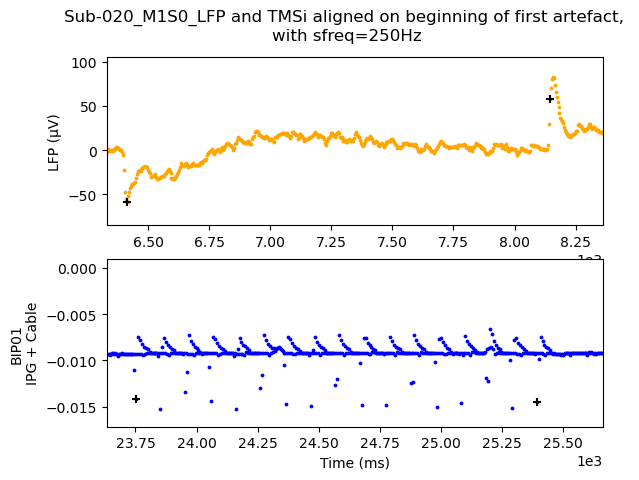

In [188]:
fig1, (ax1, ax2) = plt.subplots(2,1)
fig1.suptitle('Sub-020_M1S0_LFP and TMSi aligned on beginning of first artefact, \nwith sfreq=250Hz') #change title
ax1.ticklabel_format(axis='x',style='sci',scilimits=(3,3))
#ax1.axes.xaxis.set_ticklabels([])
ax2.ticklabel_format(axis='x',style='sci',scilimits=(3,3))
#ax2.axes.xaxis.set_ticklabels([])
ax2.set_xlabel('Time (ms)')
ax1.set_ylabel('LFP (µV)',size=10)
ax2.set_ylabel('BIP01\nIPG + Cable',size=10)
ax1.set_xlim(artefacts_x_LFP[0]-80,(artefacts_x_LFP[0]+1950))
ax2.set_xlim(artefacts_x_TMSi[0]-80,(artefacts_x_TMSi[0]+1950))
#ax2.set_ylim(0,0.005)
ax1.scatter(x1_time,LFP_Stn_L_02,color='orange',s=3) #select proper LFP channel
ax1.scatter(artefacts_x_LFP,artefacts_y_LFP,color='black',s=30,marker="+")
ax2.scatter(x2_time_downsampled,BIP01_downsampled, color='blue',s=3) #select proper sensor channel
ax2.scatter(artefacts_x_TMSi_downsampled,artefacts_y_TMSi_downsampled,color='black',s=30,marker="+")


In [172]:
fig1.savefig('C:\\Users\\Juliette\\OneDrive\\Documents\\PhD\\Figures\\Sub-020_M1S0_LFP and TMSi aligned on beginning of first artefact, with sfreq=250Hz.png',transparent=True, bbox_inches='tight')

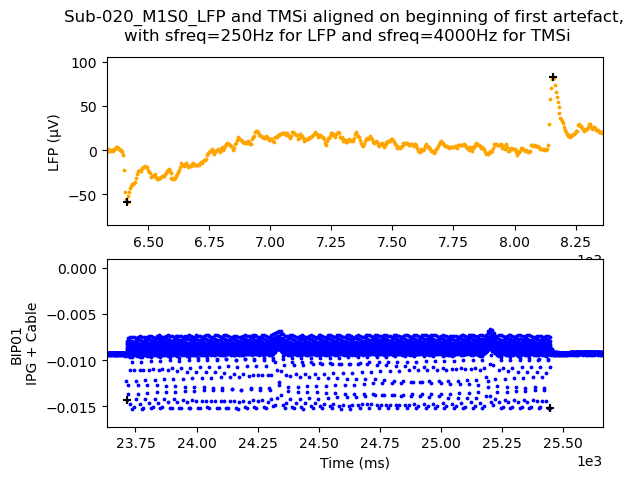

In [173]:
fig2, (ax1, ax2) = plt.subplots(2,1)
fig2.suptitle('Sub-020_M1S0_LFP and TMSi aligned on beginning of first artefact, \nwith sfreq=250Hz for LFP and sfreq=4000Hz for TMSi') #change title
ax1.ticklabel_format(axis='x',style='sci',scilimits=(3,3))
#ax1.axes.xaxis.set_ticklabels([])
ax2.ticklabel_format(axis='x',style='sci',scilimits=(3,3))
#ax2.axes.xaxis.set_ticklabels([])
ax2.set_xlabel('Time (ms)')
ax1.set_ylabel('LFP (µV)',size=10)
ax2.set_ylabel('BIP01\nIPG + Cable',size=10)
ax1.set_xlim(artefacts_x_LFP[0]-80,(artefacts_x_LFP[0]+1950))
ax2.set_xlim(artefacts_x_TMSi[0]-80,(artefacts_x_TMSi[0]+1950))
#ax2.set_ylim(0,0.005)
ax1.scatter(x1_time,LFP_Stn_L_02,color='orange',s=3) #select proper LFP channel
ax1.scatter(artefacts_x_LFP,artefacts_y_LFP,color='black',s=30,marker="+")
ax2.scatter(x2_time,BIP01, color='blue',s=3) #select proper sensor channel
ax2.scatter(artefacts_x_TMSi,artefacts_y_TMSi,color='black',s=30,marker="+")

In [174]:
fig2.savefig('C:\\Users\\Juliette\\OneDrive\\Documents\\PhD\\Figures\\Sub-020_M1S0_LFP and TMSi aligned on beginning of first artefact, with sfreq=250Hz for LFP and sfreq=4000Hz for TMSi.png',transparent=True, bbox_inches='tight')

Calculate delay between 2 artefacts in each recording:

In [199]:
delay_between_artefacts_LFP = []
delay_between_artefacts_TMSi = []
range_start = np.arange(0,len(artefacts_x_LFP),2)
range_start_bis = np.arange(2,len(artefacts_x_LFP),2)
for y,z in zip(range_start,range_start_bis):
    delay_between_artefacts_LFP.append(artefacts_x_LFP[z]-artefacts_x_LFP[y])
    delay_between_artefacts_TMSi.append(artefacts_x_TMSi[z]-artefacts_x_TMSi[y])


print(     
	f'The delays between artefacts in the LFP are \t{delay_between_artefacts_LFP} ms,'      
	f'\n\tand the delays between artefacts in the TMSi are {delay_between_artefacts_TMSi} ms')


The delays between artefacts in the LFP are 	[4812.0, 4264.0, 136488.0, 3140.0, 4536.0] ms,
	and the delays between artefacts in the TMSi are [4812.5, 4258.25, 136495.5, 3141.5, 4535.5] ms


In [200]:
diff_delay = []
w=0
for w in (np.arange(0,len(delay_between_artefacts_LFP),1)):
    diff_delay.append(delay_between_artefacts_LFP[w]-delay_between_artefacts_TMSi[w])
diff_delay

[-0.5, 5.75, -7.5, -1.5, 0.5]

Construct 2 dataframes to offset each recording based on first artefact detection and plot with same scale

In [264]:
df_LFP = pd.DataFrame({'time (ms)': x1_time, 'LFP (µV)': LFP_Stn_L_02})
df_TMSi = pd.DataFrame({'time (ms)': x2_time, 'y': BIP01})
df_LFP

,time (ms),LFP (µV)
0,0.0,-2.920584
1,4.0,-2.134273
2,8.0,-0.224660
3,12.0,1.684952
4,16.0,4.717867
...,...,...
41370,165480.0,1.572622
41371,165484.0,-2.920584
41372,165488.0,-5.391848
41373,165492.0,-7.975441


<AxesSubplot: xlabel='time (ms)'>

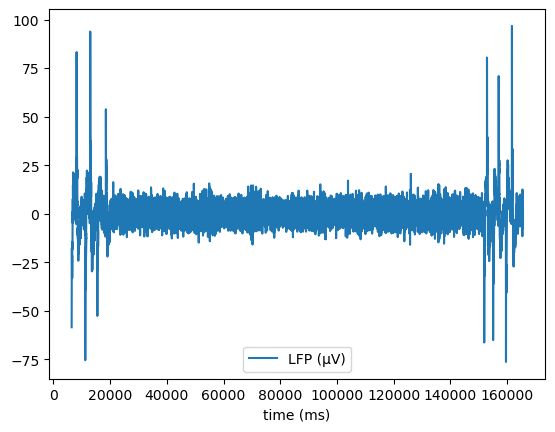

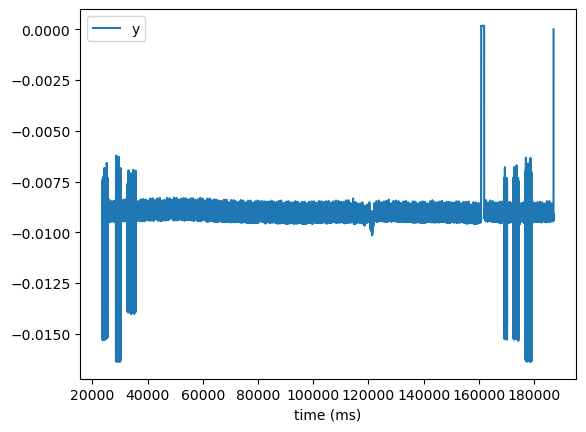

In [245]:
# find index for each artefact start
start_LFP = df_LFP[df_LFP['time (ms)'] == (artefacts_x_LFP[0])].index[0]
start_TMSi = df_TMSi[df_TMSi['time (ms)'] == (artefacts_x_TMSi[0])].index[0]

#crop each dataframe at first index
df_LFP_offset = df_LFP.truncate(before = start_LFP)
df_TMSi_offset = df_TMSi.truncate(before = start_TMSi)

#plot both dataframes
df_LFP_offset.plot(x='time (ms)',y='LFP (µV)')
df_TMSi_offset.plot(x='time (ms)',y='y')


In [246]:
x2_time_offset = df_TMSi_offset['time (ms)'].to_numpy()
TMSi_data_offset = df_TMSi_offset['y'].to_numpy()
x1_time_offset = df_LFP_offset['time (ms)'].to_numpy()
LFP_data_offset = df_LFP_offset['LFP (µV)'].to_numpy()

In [296]:
x2_time_offset_2 = np.arange(0,(187098.75-artefacts_x_TMSi[0]+0.25),0.25)
x1_time_offset_2 = np.arange(0,(165496-artefacts_x_LFP[0]+4),4)


(0.0, 160000.0)

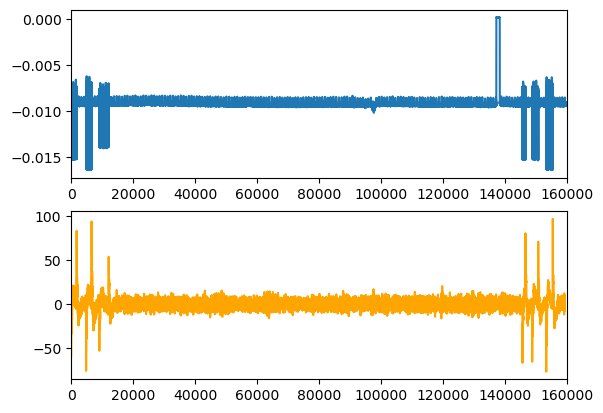

In [314]:
fig3, (ax1, ax2) = plt.subplots (2,1)
ax1.plot(x2_time_offset_2,TMSi_data_offset)
ax1.set_xlim(0,160000)
ax2.plot(x1_time_offset_2,LFP_data_offset,color='orange')
ax2.set_xlim(0,160000)

Detect artefacts in these aligned recordings and check delay

In [315]:
##start with LFP:##

#initialize variables (lists and state)
artefacts_x_LFP_offset = []
artefacts_y_LFP_offset = []
state_LFP:str = "stim_ON"

#start looking at each value one by one and append the timepoint to the proper list depending on the state and threshold crossed
for n in range(0,(len(LFP_data_offset)-1)):
    if (LFP_data_offset[n] <= -50) and (state_LFP != "stim_ON") and (LFP_data_offset[n] < LFP_data_offset[n+1]) and (LFP_data_offset[n] < LFP_data_offset[n-1]):
        artefacts_x_LFP_offset.append(x1_time_offset_2[n])
        artefacts_y_LFP_offset.append(LFP_data_offset[n])
        state_LFP = "stim_ON"
    else:
        n = n+1
         
    if (LFP_data_offset[n] >= 50) and (state_LFP != "stim_OFF"):
        artefacts_x_LFP_offset.append(x1_time_offset_2[n])
        artefacts_y_LFP_offset.append(LFP_data_offset[n])
        state_LFP = "stim_OFF"
    else:
        n = n+1
print(
    f'\n\tthe artefacts in the LFP are at: \t{artefacts_x_LFP_offset} ms')


	the artefacts in the LFP are at: 	[1732.0, 4812.0, 6552.0, 9076.0, 12072.0, 145564.0, 146528.0, 148704.0, 150652.0, 153240.0, 155324.0] ms


In [316]:
## then for TMSi: ##

#initialize variables (lists and state)
artefacts_x_TMSi_offset = []
artefacts_y_TMSi_offset = []
stimON = True
thresh = -0.0125


#start looking at each value one by one and append the timepoint to the list depending on the state and threshold crossed
for q in range(0,(len(TMSi_data_offset)-1)):
    if (stimON == False) and (TMSi_data_offset[q] <= thresh) and (TMSi_data_offset[q] < TMSi_data_offset[q+1]) and (TMSi_data_offset[q] < TMSi_data_offset[q-1]):
        artefacts_x_TMSi_offset.append(x2_time_offset_2[q])
        artefacts_y_TMSi_offset.append(TMSi_data_offset[q])
        stimON = True
        q = q+1
    if (stimON == True) and (TMSi_data_offset[q] <= thresh) and (TMSi_data_offset[q] < TMSi_data_offset[q+1]) and (TMSi_data_offset[q] < TMSi_data_offset[q-1]):
        if (all(TMSi_data_offset[(q+3):(q+100)] > thresh)):
            artefacts_x_TMSi_offset.append(x2_time_offset_2[q])
            artefacts_y_TMSi_offset.append(TMSi_data_offset[q])
            stimON = False
            q = q+1
        else:
            q = q+1
    else:
        q = q+1


print(
    f'\n\tthe artefacts in the TMSi are at: \t{artefacts_x_TMSi_offset} ms')



	the artefacts in the TMSi are at: 	[1732.5, 4812.5, 6552.75, 9070.75, 12066.25, 145566.25, 146536.5, 148707.75, 150656.0, 153243.25, 155330.0] ms


Plot both recordings with artefacts detected:

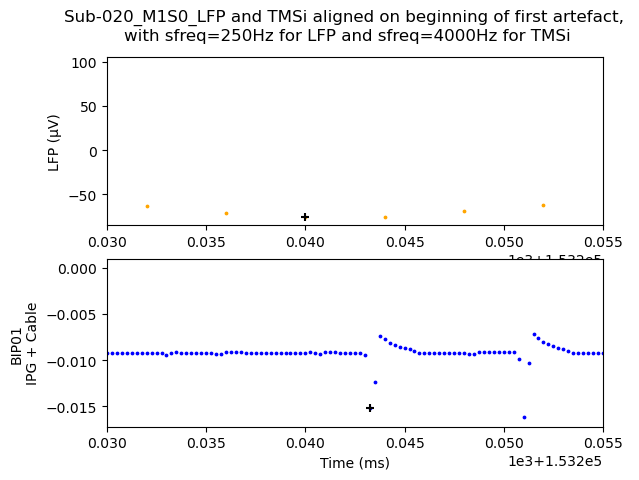

In [361]:
fig2, (ax1, ax2) = plt.subplots(2,1)
fig2.suptitle('Sub-020_M1S0_LFP and TMSi aligned on beginning of first artefact, \nwith sfreq=250Hz for LFP and sfreq=4000Hz for TMSi') #change title
ax1.ticklabel_format(axis='x',style='sci',scilimits=(3,3))
#ax1.axes.xaxis.set_ticklabels([])
ax2.ticklabel_format(axis='x',style='sci',scilimits=(3,3))
#ax2.axes.xaxis.set_ticklabels([])
ax2.set_xlabel('Time (ms)')
ax1.set_ylabel('LFP (µV)',size=10)
ax2.set_ylabel('BIP01\nIPG + Cable',size=10)
ax1.set_xlim(153230,153255)
ax2.set_xlim(153230,153255)
#ax2.set_ylim(0,0.005)
ax1.scatter(x1_time_offset_2,LFP_data_offset,color='orange',s=3) #select proper LFP channel
ax1.scatter(artefacts_x_LFP_offset,artefacts_y_LFP_offset,color='black',s=30,marker="+")
ax2.scatter(x2_time_offset_2,TMSi_data_offset, color='blue',s=3) #select proper sensor channel
ax2.scatter(artefacts_x_TMSi_offset,artefacts_y_TMSi_offset,color='black',s=30,marker="+")

Compute time differences:

In [341]:
artefacts_x_LFP_offset

[1732.0,
 4812.0,
 6552.0,
 9076.0,
 12072.0,
 145564.0,
 146528.0,
 148704.0,
 150652.0,
 153240.0,
 155324.0]

In [342]:
artefacts_x_TMSi_offset

[1732.5,
 4812.5,
 6552.75,
 9070.75,
 12066.25,
 145566.25,
 146536.5,
 148707.75,
 150656.0,
 153243.25,
 155330.0]

In [345]:
delay = []
for i in range(1,len(artefacts_x_TMSi_offset),2):
    delay.append(artefacts_x_TMSi_offset[i]-artefacts_x_LFP_offset[i])

delay

[0.5, -5.25, 2.25, 3.75, 3.25]